In [ ]:
#Binary Classification of fetal ultrasound images using a DenseNet121 Architecture and Non-Segmented datase

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [1]:
import pathlib

train_dir = "C:\\Users\\saniy\\Documents\\Rishi work\\Dataset\\training"

val_dir = 'C:\\Users\\saniy\\Documents\\Rishi work\\Dataset\\testing'

BATCH_SIZE = 4
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

NameError: name 'image_dataset_from_directory' is not defined

In [3]:
validation_dataset = image_dataset_from_directory(val_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 180 files belonging to 2 classes.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

NameError: name 'test_dataset' is not defined

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

AttributeError: 'PrefetchDataset' object has no attribute 'class_names'

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

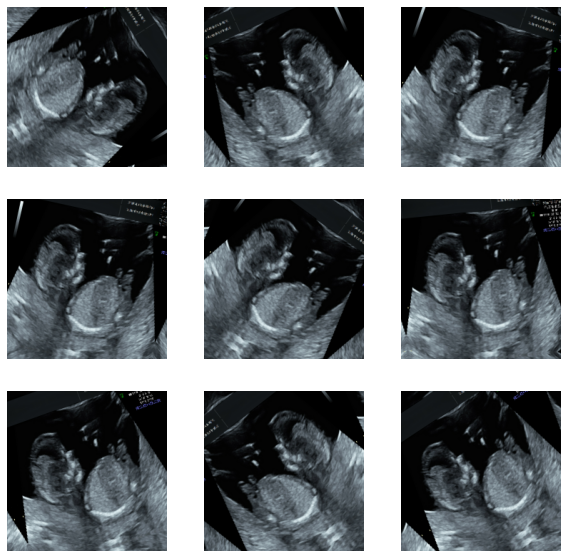

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [8]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

In [9]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./225)

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(4, 7, 7, 1024)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(4, 1024)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(4, 1)


In [16]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0     

In [19]:
len(model.trainable_variables)

2

In [20]:
initial_epochs = 50

loss0, accuracy0 = model.evaluate(validation_dataset)

36/36 [==============================] - 17s 369ms/step - loss: 0.6744 - accuracy: 0.5197


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/50
180/180 [==============================] - 95s 489ms/step - loss: 0.8269 - accuracy: 0.4597 - val_loss: 0.6702 - val_accuracy: 0.5833
Epoch 2/50
180/180 [==============================] - 83s 458ms/step - loss: 0.8116 - accuracy: 0.4667 - val_loss: 0.6475 - val_accuracy: 0.6667
Epoch 3/50
180/180 [==============================] - 84s 466ms/step - loss: 0.7922 - accuracy: 0.4653 - val_loss: 0.6145 - val_accuracy: 0.6111
Epoch 4/50
180/180 [==============================] - 83s 461ms/step - loss: 0.7408 - accuracy: 0.5208 - val_loss: 0.5887 - val_accuracy: 0.6736
Epoch 5/50
180/180 [==============================] - 84s 464ms/step - loss: 0.7305 - accuracy: 0.5194 - val_loss: 0.5714 - val_accuracy: 0.7153
Epoch 6/50
180/180 [==============================] - 83s 462ms/step - loss: 0.7023 - accuracy: 0.5431 - val_loss: 0.5695 - val_accuracy: 0.7361
Epoch 7/50
180/180 [==============================] - 84s 466ms/step - loss: 0.6871 - accuracy: 0.5569 - val_loss: 0.5507 - val_ac

In [1]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet121 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model_accuracy_DenseNet(5).svg')
plt.show()
    
    # "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet121 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('Model_loss_DenseNet(5).svg')
plt.show()




NameError: name 'plt' is not defined

In [2]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'history' is not defined

['Bad', 'Good']
good


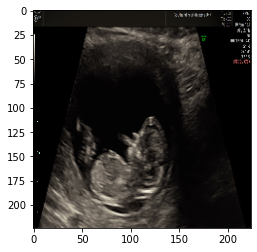

In [57]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.preprocessing import image
from cv2 import *
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing import image
img = cv2.imread('/Users/RishiSingh/crl-images/dataset/single_prediction/CRL (1013).jpg')
img = cv2.resize(img, (224,224))
plt.imshow(img)
test_image = image.load_img('/Users/RishiSingh/crl-images/dataset/single_prediction/CRL (1013).jpg', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
print(class_names)
if result[0][0] >0.5:
  prediction = 'good'
else:
  prediction = 'bad'
print(prediction)


In [58]:
model.save(os.path.join(os.getcwd(),"DenseNet121.h5"))